# Import statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import json
import os
from collections import Counter
import joblib

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    cross_val_score,
    RepeatedStratifiedKFold)
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    auc,
    balanced_accuracy_score,
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report)
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
from lime_stability.stability import LimeTabularExplainerOvr, LimeBaseOvr
import random
import gc
import contextlib
import warnings
import shap
import fasttreeshap
from scipy.stats import spearmanr, kendalltau, ttest_rel
from itertools import combinations
import xgboost
from xgboost import XGBClassifier
#import cudf
#from dask_cuda import LocalCUDACluster
#from dask.distributed import Client
#import dask.array as da
#from dask_ml.model_selection import GridSearchCV
from catboost import CatBoostClassifier, Pool


shap.initjs()

# Set display options
pd.options.display.max_columns = 80
pd.set_option('display.precision', 15)

random_state = 42

# Data wrangling

In [2]:
# CICIDS2017
#df = pd.read_parquet('datasets/cicids2017/cicids17-pre-processed.parquet')
#dataset_name = "cicids2017"

# cicids18
df = pd.read_parquet('datasets/cicids18/cicids18-pre-processed.parquet')
dataset_name = "cicids18"

In [3]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16232943 entries, 0 to 16232942
Data columns (total 64 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int32  
 1   Protocol           int32  
 2   Flow Duration      int32  
 3   Tot Fwd Pkts       int32  
 4   Tot Bwd Pkts       int32  
 5   TotLen Fwd Pkts    int32  
 6   TotLen Bwd Pkts    float32
 7   Fwd Pkt Len Max    int32  
 8   Fwd Pkt Len Min    int32  
 9   Fwd Pkt Len Mean   float32
 10  Fwd Pkt Len Std    float32
 11  Bwd Pkt Len Max    int32  
 12  Bwd Pkt Len Min    int32  
 13  Bwd Pkt Len Mean   float32
 14  Bwd Pkt Len Std    float32
 15  Flow Byts/s        float64
 16  Flow Pkts/s        float32
 17  Flow IAT Mean      float32
 18  Flow IAT Std       float32
 19  Flow IAT Max       float32
 20  Flow IAT Min       float32
 21  Fwd IAT Tot        float32
 22  Fwd IAT Mean       float32
 23  Fwd IAT Std        float32
 24  Fwd IAT Max        float32
 25  Fwd IAT Min     

## Visualization of raw data

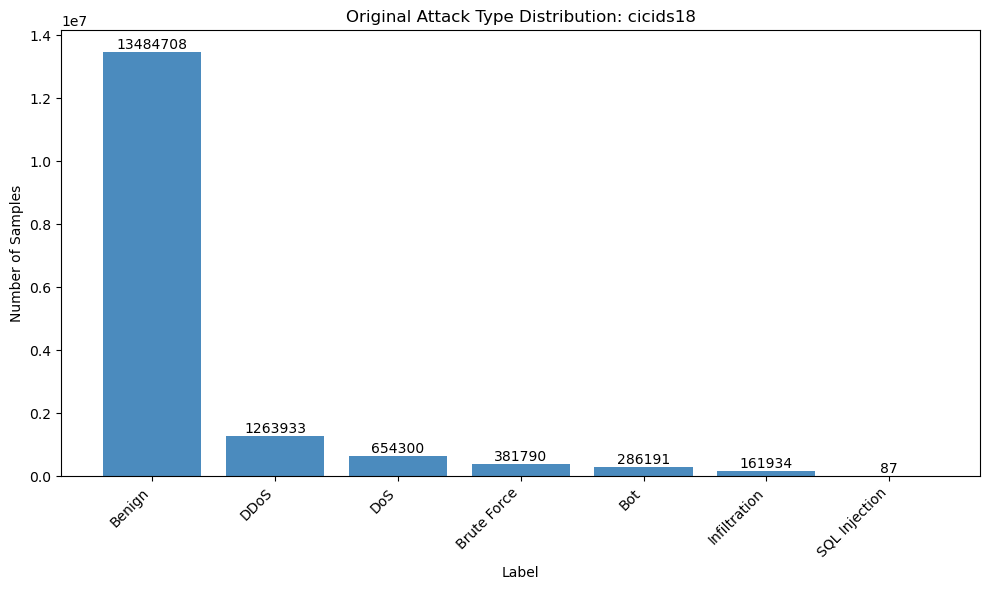

In [4]:
# Visualization of cleaned dataset
df['Label'] = df['Label'].str.replace('Infilteration', 'Infiltration')

category_counts = df['Label'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index, category_counts.values, color='#4B8BBE')
plt.title(f'Original Attack Type Distribution: {dataset_name}')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=10
    )

plt.show()

## Label encoding

In [5]:
le = LabelEncoder()
df['Attack_code'] = le.fit_transform(df['Label'])

print(df['Attack_code'].unique())

[0 1 4 2 6 3 5]


In [6]:
# Printing corresponding attack type for each encoded value
encoded_labels = df['Attack_code'].unique()

for val in sorted(encoded_labels):
    print(f"{val}: {le.inverse_transform([val])[0]}")   

0: Benign
1: Bot
2: Brute Force
3: DDoS
4: DoS
5: Infiltration
6: SQL Injection


In [7]:
df.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Attack_code
0,443,6,141385,9,7,553,3773.0,202,0,61.444442749023438,87.534439086914062,1460,0,539.000000000000000,655.43292236328125,30597.305230000001757,113.166175842285156,9425.6669921875,19069.117187500000000,73403.0,1.0,141385.0,17673.12500000,23965.32421875,73403.0,22.0,51417.0,8569.500000000,13036.89062500,31525.0,1.0,0,0,192,152,63.655975341796875,49.510204315185547,0,1460,254.470581054687500,474.712951660156250,225352.390625000000000,0,1,1,0,0,1,0,270.375000000000000,3773,8192,119,4,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
1,49684,6,281,2,1,38,0.0,38,0,19.000000000000000,26.870058059692383,0,0,0.000000000000000,0.00000000000000,135231.316699999995762,10676.156250000000000,140.5000000000,174.655380249023438,264.0,17.0,281.0,281.00000000,0.00000000,281.0,281.0,0.0,0.000000000,0.00000000,0.0,0.0,1,0,40,20,7117.437500000000000,3558.718750000000000,0,38,19.000000000000000,21.939310073852539,481.333343505859375,0,0,0,1,0,0,0,25.333333969116211,0,123,0,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
2,443,6,279824,11,15,1086,10527.0,385,0,98.727272033691406,129.392501831054688,1460,0,701.799987792968750,636.31420898437500,41501.086400000000140,92.915550231933594,11192.9599609375,24379.449218750000000,112589.0,1.0,279728.0,27972.80078125,36167.74218750,112589.0,94.0,258924.0,18494.572265625,36356.50390625,133669.0,1.0,0,0,232,312,39.310424804687500,53.605121612548828,0,1460,430.111114501953125,566.234191894531250,320621.187500000000000,0,1,1,0,0,1,1,446.653839111328125,10527,8192,1047,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
3,443,6,132,2,0,0,0.0,0,0,0.000000000000000,0.000000000000000,0,0,0.000000000000000,0.00000000000000,0.000000000000000,15151.515625000000000,132.0000000000,0.000000000000000,132.0,132.0,132.0,132.00000000,0.00000000,132.0,132.0,0.0,0.000000000,0.00000000,0.0,0.0,0,0,40,0,15151.515625000000000,0.000000000000000,0,0,0.000000000000000,0.000000000000000,0.000000000000000,0,0,0,1,0,0,0,0.000000000000000,0,256,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
4,443,6,274016,9,13,1285,6141.0,517,0,142.777770996093750,183.887725830078125,1460,0,472.384613037109375,611.18048095703125,27100.607260000000679,80.287284851074219,13048.3808593750,26311.626953125000000,114077.0,1.0,273946.0,34243.25000000,37996.56640625,114077.0,201.0,252994.0,21082.833984375,39075.73828125,135611.0,1.0,0,0,192,272,32.844799041748047,47.442485809326172,0,1460,322.869567871093750,497.254760742187500,247262.296875000000000,0,1,1,0,0,1,1,337.545440673828125,6141,8192,1047,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0


# (Testing) Downsampling for Testing Purposes

In [ ]:
# drastically downsample beningn traffic to maintain small attack samples
# optionally it could have helped to classify all attack types under "attack" type so binary classification is possible

df_benign = df[df['Attack_code'] == 0]
df_attacks = df[df['Attack_code'] != 0]

# Downsample beningn to match total attack samples (or custom ratio)
sample_size_benign = len(df_attacks)  # 1:1 ratio
# sample_size_benign = 2 * len(df_attacks)  # 2:1 ratio

df_benign_downsampled = resample(df_benign,
                                 replace=False,
                                 n_samples=sample_size_benign,
                                 random_state=random_state)
df = pd.concat([df_benign_downsampled, df_attacks])

In [ ]:
category_counts = df['Attack_type'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index, category_counts.values, color='#4B8BBE')
plt.title('Downsampled Attack Type Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=10
    )

plt.show()

# Data Splitting

In [8]:
# Prepare data
y = df.pop("Attack_code")
X = df.drop(columns=["Label"])

In [9]:
X.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'FIN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts

In [10]:
#
#
#
# The dataset is highly imbalanced. Could be adressed usind SMOTE or undersampling (http://www.ijnc.org/index.php/ijnc/article/view/293)

In [11]:
# Split into train, validation, test (60/20/20) # change to recommended proportion Kelleher, p. 541 (50/20/30) vs 70/30 (arreche, p. 23960)


# First split 30% test, 70% train+val
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    test_size=0.3,  # 30% for test
    random_state=random_state,
    stratify=y
)

# Now split trainval into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.2857,  # 20% of total = 0.2857 * 70% ≈ 20%
    random_state=random_state,
    stratify=y_trainval
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")


Train: (8116633, 63), Val: (3246427, 63), Test: (4869883, 63)
Train: (8116633,), Val: (3246427,), Test: (4869883,)


In [12]:
print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


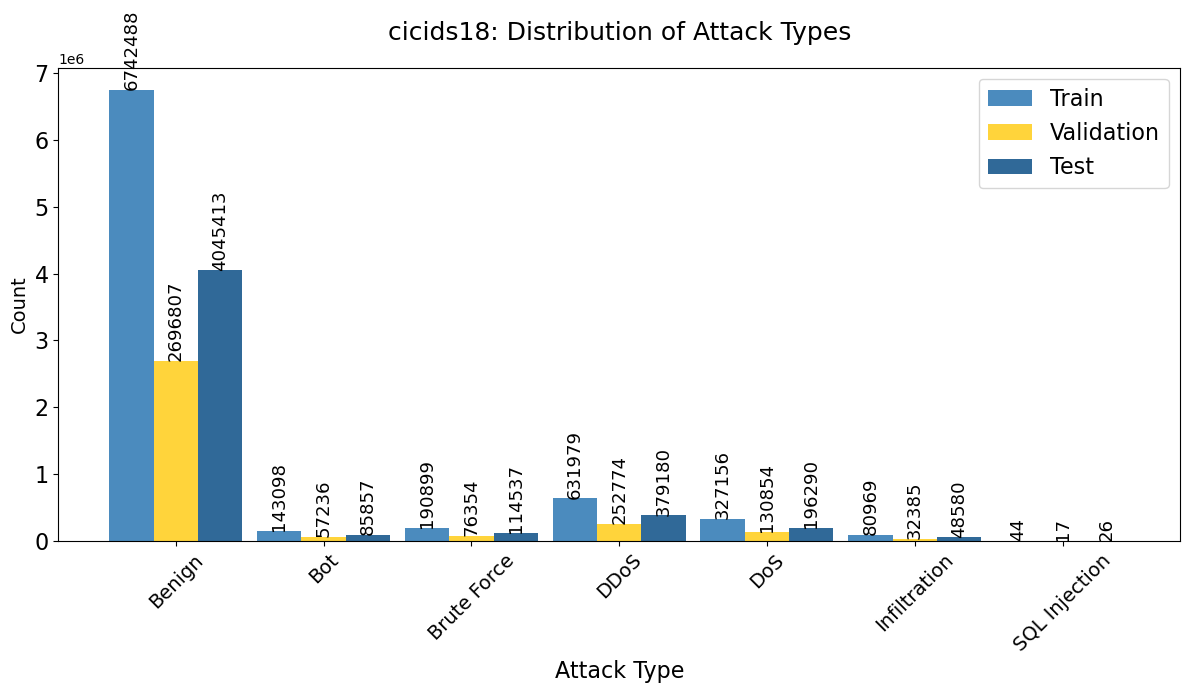

In [13]:
# Get counts for each split
train_counts = y_train.value_counts().sort_index()
val_counts = y_val.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

all_codes = list(set(y_train.unique()) | set(y_val.unique()) | set(y_test.unique()))
decoded_labels = le.inverse_transform(all_codes)

dist_df = pd.DataFrame({
    'Train': [train_counts.get(code, 0) for code in all_codes],
    'Validation': [val_counts.get(code, 0) for code in all_codes],
    'Test': [test_counts.get(code, 0) for code in all_codes]
}, index=decoded_labels)

plt.figure(figsize=(12, 7)) 
bar_width = 0.3 
x = range(len(decoded_labels))

bars_train = plt.bar([i - bar_width for i in x], dist_df['Train'], width=bar_width, label='Train', color='#4B8BBE')
bars_val = plt.bar(x, dist_df['Validation'], width=bar_width, label='Validation', color='#FFD43B')
bars_test = plt.bar([i + bar_width for i in x], dist_df['Test'], width=bar_width, label='Test', color='#306998')

plt.xlabel('Attack Type', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.title(f'{dataset_name}: Distribution of Attack Types', fontsize=18, pad=20)

# Axis Ticks
plt.xticks(x, decoded_labels, rotation=45, fontsize=14)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

# Add count labels on each bar
for bars in [bars_train, bars_val, bars_test]:
    for bar in bars:
        height = bar.get_height()
        if height > 0: 
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center', 
                va='bottom', 
                fontsize=13,  
                rotation=90
            )

plt.tight_layout()
plt.savefig(f'metrics/final plots/{dataset_name}_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

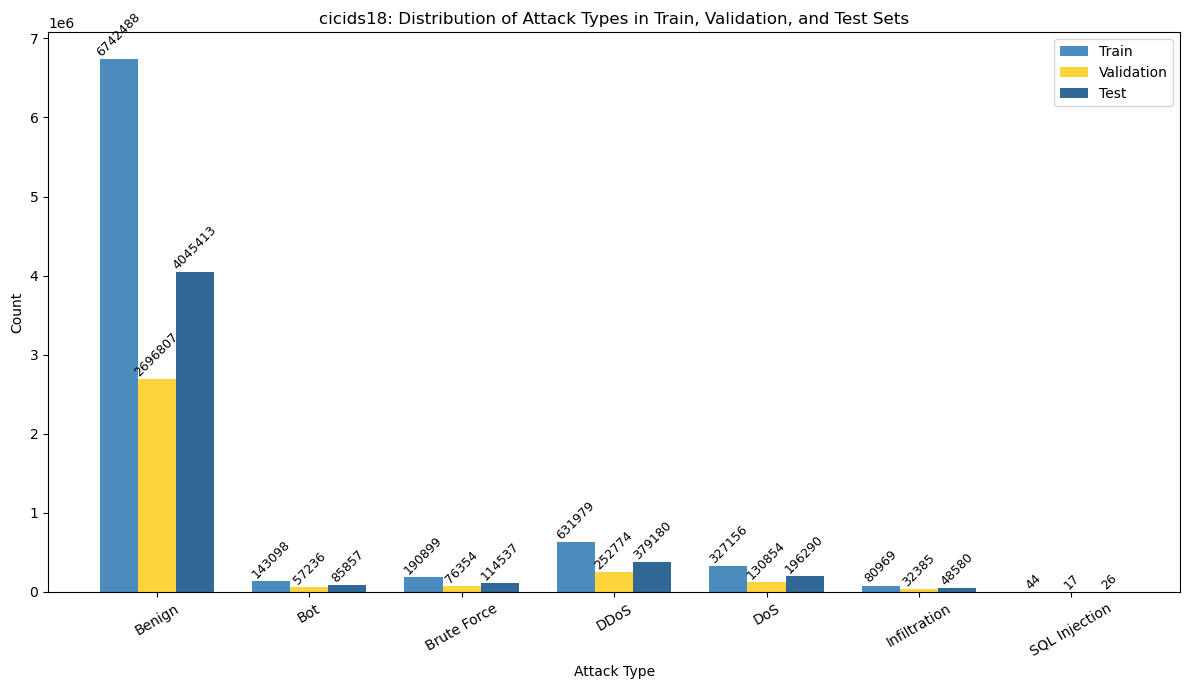

In [14]:
# Get counts for each split
train_counts = y_train.value_counts().sort_index()
val_counts = y_val.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

# Get all unique attack codes (ensure all bars align)
all_codes = list(set(y_train.unique()) | set(y_val.unique()) | set(y_test.unique()))

# Decode attack codes to attack type labels
decoded_labels = le.inverse_transform(all_codes)

# Create DataFrame for distribution
dist_df = pd.DataFrame({
    'Train': [train_counts.get(code, 0) for code in all_codes],
    'Validation': [val_counts.get(code, 0) for code in all_codes],
    'Test': [test_counts.get(code, 0) for code in all_codes]
}, index=decoded_labels)

plt.figure(figsize=(12, 7))
bar_width = 0.25
x = range(len(decoded_labels))

bars_train = plt.bar([i - bar_width for i in x], dist_df['Train'], width=bar_width, label='Train', color='#4B8BBE')
bars_val = plt.bar(x, dist_df['Validation'], width=bar_width, label='Validation', color='#FFD43B')
bars_test = plt.bar([i + bar_width for i in x], dist_df['Test'], width=bar_width, label='Test', color='#306998')

plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.title(f'{dataset_name}: Distribution of Attack Types in Train, Validation, and Test Sets')
plt.xticks(x, decoded_labels, rotation=30)
plt.legend()

# Add count labels on each bar
for bars in [bars_train, bars_val, bars_test]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9, rotation=45
        )

plt.tight_layout()
plt.show()


## Data Persistance

In [15]:
"""
"# Save Data to Disk
X_train.to_parquet(f'datasets/{dataset_name}/TrainValTest/X_train.parquet')
y_train.to_frame().to_parquet(f'datasets/{dataset_name}/TrainValTest/y_train.parquet')
X_val.to_parquet(f'datasets/{dataset_name}/TrainValTest/X_val.parquet')
y_val.to_frame().to_parquet(f'datasets/{dataset_name}/TrainValTest/y_val.parquet')
X_test.to_parquet(f'datasets/{dataset_name}/TrainValTest/X_test.parquet')
y_test.to_frame().to_parquet(f'datasets/{dataset_name}/TrainValTest/y_test.parquet')
"""

'\n"# Save Data to Disk\nX_train.to_parquet(f\'datasets/{dataset_name}/TrainValTest/X_train.parquet\')\ny_train.to_frame().to_parquet(f\'datasets/{dataset_name}/TrainValTest/y_train.parquet\')\nX_val.to_parquet(f\'datasets/{dataset_name}/TrainValTest/X_val.parquet\')\ny_val.to_frame().to_parquet(f\'datasets/{dataset_name}/TrainValTest/y_val.parquet\')\nX_test.to_parquet(f\'datasets/{dataset_name}/TrainValTest/X_test.parquet\')\ny_test.to_frame().to_parquet(f\'datasets/{dataset_name}/TrainValTest/y_test.parquet\')\n'

In [16]:
#dataset_name = "cicids18"

In [17]:
"""
X_train = pd.read_parquet(f'datasets/{dataset_name}/TrainValTest/X_train.parquet')
y_train = pd.read_parquet(f'datasets/{dataset_name}/TrainValTest/y_train.parquet')
print(X_train.shape, y_train.shape)
"""

"\nX_train = pd.read_parquet(f'datasets/{dataset_name}/TrainValTest/X_train.parquet')\ny_train = pd.read_parquet(f'datasets/{dataset_name}/TrainValTest/y_train.parquet')\nprint(X_train.shape, y_train.shape)\n"

In [18]:
"""
X_val = pd.read_parquet(f'datasets/{dataset_name}/TrainValTest/X_val.parquet')
y_val = pd.read_parquet(f'datasets/{dataset_name}/TrainValTest/y_val.parquet')
print(X_val.shape, y_val.shape)
"""

"\nX_val = pd.read_parquet(f'datasets/{dataset_name}/TrainValTest/X_val.parquet')\ny_val = pd.read_parquet(f'datasets/{dataset_name}/TrainValTest/y_val.parquet')\nprint(X_val.shape, y_val.shape)\n"

In [19]:
#y_train.head()

In [20]:
#del X_trainval, y_trainval, X_val, X_test, y_val, y_test, df, X, y
#gc.collect()

# (Testing) Downsampling for SMOTE

In [ ]:
X_smote, _, y_smote, _ = train_test_split(
    X_train, y_train, train_size=500000,
    shuffle=True,
    random_state=random_state
)

X_smote.info()

In [ ]:
# Get counts for each attack code in the SMOTE sample
smote_counts = pd.Series(y_smote).value_counts().sort_index()

# Decode attack codes to attack type labels
decoded_labels = le.inverse_transform(smote_counts.index)

plt.figure(figsize=(12, 7))
bar_width = 0.5
x = np.arange(len(decoded_labels))

bars_smote = plt.bar(x, smote_counts.values, width=bar_width, color='#306998', label='SMOTE Sample')

plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.title('Distribution of Attack Types in SMOTE Sample Set')
plt.xticks(x, decoded_labels, rotation=30)
plt.legend()

# Add count labels on each bar
for bar in bars_smote:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,  # Small offset above bar
        f'{int(height)}',
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()

# Model Tuning and Setup

In [15]:
models = []
save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)

In [22]:
randomForest = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    max_depth=10,
    class_weight='balanced',
    random_state=random_state,
    n_jobs=-1,
    verbose=0
)
randomForest.fit(X_train, y_train)
rf_dict = {
    "name": "RandomForest",
    "model": randomForest
}
print("Storing RF")
joblib.dump(randomForest, "models/cicids18_RandomForest_new")
models.append(rf_dict)

            #cicids17 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
            #cicids18 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 1.0}

num_class = len(y_train.unique())
xgb = XGBClassifier(
    device='cpu',
    objective='multi:softprob',
    num_class=num_class,
    booster='gbtree',
    random_state=random_state,
    max_depth=7,
    learning_rate=0.1,
    n_estimators=500,
    subsample=1.0,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_dict = {
    "name": "XGBoost",
    "model": xgb
}
print("Storing XGB")
xgb.save_model("models/cicids18_XGB.json")
joblib.dump(xgb, "models/cicids18_XGB_new")
models.append(xgb_dict)

            #cicids17  {'depth': 5, 'iterations': 1000, 'learning_rate': 0.1}
            #cicids18 {'depth': 7, 'iterations': 1000, 'learning_rate': 0.1}

catb = catboost = CatBoostClassifier(
    loss_function='MultiClass',
    bootstrap_type='Bayesian',
    random_seed=random_state,
    verbose=False,
    depth=7,
    iterations=1000,
    learning_rate=0.1
    )
catb.fit(X_train, y_train)
catb_dict = {
    "name": "CatBoost",
    "model": catb
}
print("Storing CatB")
joblib.dump(catb, "models/cicids18_CatBoost_new")
models.append(catb_dict)


Storing RF
Storing XGB
Storing CatB


In [16]:
rf = joblib.load("models/cicids18_RandomForest.joblib")
rf_dict = {
    "name": "RandomForest",
    "model": rf
}
models.append(rf_dict)

xgb = joblib.load("models/cicids18_XGBoost.joblib")
xgb_dict = {
    "name": "XGBoost",
    "model": xgb
}
models.append(xgb_dict)

cb = joblib.load("models/cicids18_CatBoost.joblib")
cb_dict = {
    "name": "CatBoost",
    "model": cb
}
models.append(cb_dict)

[14:18:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.



In [30]:
grid_searchRF = joblib.load('models/cicids18_CatBoost_gridsearch.joblib')
randomForest = grid_searchRF.best_estimator_

rf_dict = {
    "name": "RandomForest",
    "model": randomForest
}
print("Best parameters:", grid_searchRF.best_params_)
models.append(rf_dict)

grid_searchXGB = joblib.load('models/cicids18_XGBoost_gridsearch.joblib')
XGB = grid_searchXGB.best_estimator_

xgb_dict = {
    "name": "XGBoost",
    "model": XGB
}
print("Best parameters:", grid_searchXGB.best_params_)
models.append(xgb_dict)

grid_searchcat = joblib.load('models/cicids18_CatBoost_gridsearch.joblib')
cb = grid_searchcat.best_estimator_

cb_dict = {
    "name": "CatBoost",
    "model": cb
}
print("Best parameters:", grid_searchcat.best_params_)
models.append(cb_dict)

Best parameters: {'depth': 7, 'iterations': 500, 'learning_rate': 0.1}
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Best parameters: {'depth': 7, 'iterations': 500, 'learning_rate': 0.1}


In [17]:
models

[{'name': 'RandomForest',
  'model': RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=50,
                         n_jobs=-1, random_state=42)},
 {'name': 'XGBoost',
  'model': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device='cpu', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=500, n_jobs=None, num_class=7,
                num_parallel_tree=None, ...)},
 {'name': 'CatBoost',
  

In [32]:
# Load the saved GridSearchCV model
grid_searchRF = joblib.load("models/cicids18_RandomForest_gridsearch.joblib")
randomForest = grid_searchRF.best_estimator_
print(f"Loaded RandomForest model from models/cicids18_RandomForest_gridsearch.joblib")
rf_dict = {
    "name": "RandomForest",
    "model": randomForest
}
# Print best parameters and score
print("Best parameters:", grid_searchRF.best_params_)
print("Best cross-validation score:", grid_searchRF.best_score_)

models.append(rf_dict)

Loaded RandomForest model from models/cicids18_RandomForest_gridsearch.joblib
Best parameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.8526647907090833


## Random Forest

In [21]:
# Apply gridsearch for hyperparameter tuning

file_path = os.path.join(save_dir, f"{dataset_name}_RF_gridsearch.joblib")

if os.path.isfile(file_path):

    # Load the saved GridSearchCV model
    grid_searchRF = joblib.load(file_path)
    randomForest = grid_searchRF.best_estimator_
    print(f"Loaded RandomForest model from {file_path}")

else:

    print("Starting GridSearchCV for RF")
    start_time = time.perf_counter()

    param_grid = {
        'n_estimators': [50, 200, 500],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        #'min_samples_leaf': [1, 2, 4]
    }

    rf = RandomForestClassifier(
        class_weight='balanced',
        random_state=random_state,
        n_jobs=-1,
        verbose=0
    )

    grid_searchRF = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='balanced_accuracy',
        n_jobs=-1, # max. 3?
        verbose=1
    )

    grid_searchRF.fit(X_train, y_train)
    #print(f"Best parameters: {grid_searchRF.best_params_}")
    #print(f"Best cross-validation score: {grid_searchRF.best_score_:.4f}")

    end_time = time.perf_counter()
    elapsed = end_time - start_time
    print(f"Time taken: {elapsed:.2f} seconds")

    # Save the GridSearchCV object
    randomForest = grid_searchRF.best_estimator_    
    joblib.dump(randomForest, f"{dataset_name}_RandomForest.joblib")
    joblib.dump(grid_searchRF, f"{dataset_name}_RandomForest_gridsearch.joblib")
    print(f"Random Forest model saved to {file_path}")

rf_dict = {
    "name": "RandomForest",
    "model": randomForest
}
# Print best parameters and score
print("Best parameters:", grid_searchRF.best_params_)
print("Best cross-validation score:", grid_searchRF.best_score_)

models.append(rf_dict)


Starting GridSearchCV for RF
Fitting 5 folds for each of 36 candidates, totalling 180 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Time taken: 73064.47 seconds
Random Forest model saved to models/cicids18_RF_gridsearch.joblib
Best parameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.8526647907090833


In [23]:
models

[{'name': 'RandomForest',
  'model': RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=50,
                         n_jobs=-1, random_state=42)}]

## XGBoost

In [33]:
grid_searchXGB = joblib.load("models/cicids18_XGBoost_gridsearch.joblib")
xgBoost = grid_searchXGB.best_estimator_
print(f"Loaded XGBoost model from models/cicids18_XGBoost_gridsearch.joblib")
print("Best parameters:", grid_searchXGB.best_params_)
print("Best cross-validation score:", grid_searchXGB.best_score_)

# Add model to list
xgb_dict = {
    "name": "XGBoost",
    "model": xgBoost
}
models.append(xgb_dict)

Loaded XGBoost model from models/cicids18_XGBoost_gridsearch.joblib
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Best cross-validation score: 0.7516950626893582


In [22]:
file_path = os.path.join(save_dir, f"{dataset_name}_XGB_gridsearch.joblib")  # Use .pkl for joblib

if os.path.isfile(file_path):
    # Load the saved GridSearchCV object
    grid_searchXGB = joblib.load(file_path)
    xgBoost = grid_searchXGB.best_estimator_
    print(f"Loaded XGBoost model from {file_path}")
    print("Best parameters:", grid_searchXGB.best_params_)
    print("Best cross-validation score:", grid_searchXGB.best_score_)

else:
    print("Start GridSearchCV for XGB")
    start_time = time.perf_counter()

    # Define parameter grid
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        #'subsample': [0.8, 1.0],
        'n_estimators': [50, 200, 500]
    }

    # Initialize XGBClassifier
    xgb = XGBClassifier(
        device='cpu',
        objective='multi:softprob',
        num_class=len(encoded_labels),
        booster='gbtree',
        random_state=random_state
    )

    # Initialize GridSearchCV
    grid_searchXGB = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=5,
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=2
    )

    # Fit GridSearchCV
    grid_searchXGB.fit(X_train, y_train)

    end_time = time.perf_counter()
    elapsed = end_time - start_time
    print(f"Time taken: {elapsed:.2f} seconds")

    # Print best parameters and score
    print("Best parameters:", grid_searchXGB.best_params_)
    print("Best cross-validation score:", grid_searchXGB.best_score_)

    xgBoost = grid_searchXGB.best_estimator_

    # Save the GridSearchCV object with joblib
    joblib.dump(grid_searchXGB, file_path)
    joblib.dump(xgBoost, f"{dataset_name}_XGBoost.joblib")
    joblib.dump(grid_searchXGB, f"{dataset_name}_XGBoost_gridsearch.joblib")
    xgBoost.save_model(f"models/{dataset_name}_XGB.json")
    print(f"XGBoost model saved to {file_path}")

# Add model to list
xgb_dict = {
    "name": "XGBoost",
    "model": xgBoost
}
models.append(xgb_dict)


Start GridSearchCV for XGB
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=10.6min


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=11.0min
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=12.1min
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=11.0min
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=12.2min
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=10.3min
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time= 9.9min
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=13.5min
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time= 9.9min
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=10.1min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=40.0min
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=10.0min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=47.5min
[CV] END ...learning_rate=0.

## CatBoost

In [21]:
# Load the saved GridSearchCV object
grid_searchCat = joblib.load("models/cicids18_CatBoost_gridsearch.joblib")
catBoost = grid_searchCat.best_estimator_
print(f"Loaded CatBoost model from models/cicids18_CatBoost.joblib")
cat_dict = {
"name": "CatBoost",
"model": catBoost
}

# Print best parameters and score
print("Best parameters:", grid_searchCat.best_params_)
print("Best cross-validation score:", grid_searchCat.best_score_)

models.append(cat_dict)

Loaded CatBoost model from models/cicids18_CatBoost.joblib
Best parameters: {'depth': 7, 'iterations': 500, 'learning_rate': 0.1}
Best cross-validation score: 0.734147079165059


In [ ]:
file_path = os.path.join(save_dir, f"{dataset_name}_CatBoost_gridsearch.joblib")

if os.path.isfile(file_path):
    # Load the saved GridSearchCV object
    grid_searchCat = joblib.load(file_path)
    catBoost = grid_searchCat.best_estimator_
    print(f"Loaded CatBoost model from {file_path}")

else:
    print("Start GridSearchCV for CatBoost")
    start_time = time.perf_counter()


    param_grid = {
        'depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        #'subsample': [0.8, 1.0], # bayesian bootstrap doesn't support 'subsample' option
        'iterations': [50, 200, 500],
        #'n_estimators': [50, 200, 500] # only one of the parameters iterations, n_estimators, num_boost_round, num_trees should be initialized
    }

    # Initialize CatBoostClassifier
    catboost_model = CatBoostClassifier(
        loss_function='MultiClass',
        bootstrap_type='Bayesian',
        random_seed=random_state,
        verbose=False
    )

    # Initialize GridSearchCV
    grid_searchCat = GridSearchCV(
        estimator=catboost_model,
        param_grid=param_grid,
        cv=5,
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=2
    )

    # Fit GridSearchCV
    grid_searchCat.fit(X_train, y_train)

    # Save the GridSearchCV object
    catBoost = grid_searchCat.best_estimator_
    joblib.dump(catBoost, f"{dataset_name}_CatBoost.joblib")
    joblib.dump(grid_searchCat, f"{dataset_name}_CatBoost_gridsearch.joblib")
    print(f"CatBoost model saved to {file_path}")

    end_time = time.perf_counter()
    elapsed = end_time - start_time
    print(f"Time taken: {elapsed:.2f} seconds")

cat_dict = {
    "name": "CatBoost",
    "model": catBoost
}


# Print best parameters and score
print("Best parameters:", grid_searchCat.best_params_)
print("Best cross-validation score:", grid_searchCat.best_score_)

models.append(cat_dict)


Start GridSearchCV for CatBoost
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .........depth=3, iterations=200, learning_rate=0.1; total time=87.3min
[CV] END .........depth=5, iterations=50, learning_rate=0.01; total time=35.5min


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV] END .........depth=3, iterations=200, learning_rate=0.1; total time=87.6min
[CV] END .........depth=5, iterations=50, learning_rate=0.01; total time=35.4min


In [27]:
models

[{'name': 'RandomForest',
  'model': RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=50,
                         n_jobs=-1, random_state=42)},
 {'name': 'XGBoost',
  'model': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device='cpu', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                feature_weights=None, gamma=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.1, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, multi_strategy=None, n_estimators=500,
                n_jobs=None, num_class=7, ...)},
 {'name': 'CatBoost',
  'm

# (Testing) Classifier Model Setup

## Random Forest Model

In [ ]:
# prepare model collection

models = []


In [ ]:

# Paths for saved models
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'RandomForest.joblib')

# Check if model file exists
if os.path.exists(model_path):
    # Load model
    randomForest = joblib.load(model_path)
    print("Model loaded from disk.")

else:
    start_time = time.perf_counter()

    # Build Classifier
    randomForest = RandomForestClassifier(
        n_estimators=50,
        max_depth=None,
        n_jobs=-2, # all but one
        random_state=random_state,
        verbose=0,
        class_weight='balanced'
    )

    # Train model
    print("Training Random Forest")
    randomForest.fit(X_train, y_train)

    end_time = time.perf_counter()
    print(f"Model trained in {end_time - start_time:.2f} seconds.")

    # Save model
    joblib.dump(randomForest, model_path)
    print(f"Model saved to {model_dir}.")

models.append(randomForest)

In [ ]:
print(models)


## XGBoost

## Catboost

# (Testing) Feature Selection

## Feature cross validation

## Dataset creation

# Model Evaluation Training and Validation

## Confusion Matrices

Model: RandomForest - Training: 
Accuracy: 0.6779, 
Precision: 0.9703, 
Recall: 0.6779, 
F1: 0.7854, 
AUC: 0.9831, 
Balanced Accuracy: 0.8715
               precision    recall  f1-score   support

       Benign       0.99      0.62      0.77   6742488
          Bot       0.91      1.00      0.95    143098
  Brute Force       0.83      0.95      0.89    190899
         DDoS       0.90      1.00      0.95    631979
          DoS       0.95      0.89      0.92    327156
 Infiltration       0.02      0.67      0.05     80969
SQL Injection       0.00      0.98      0.00        44

     accuracy                           0.68   8116633
    macro avg       0.66      0.87      0.65   8116633
 weighted avg       0.97      0.68      0.79   8116633



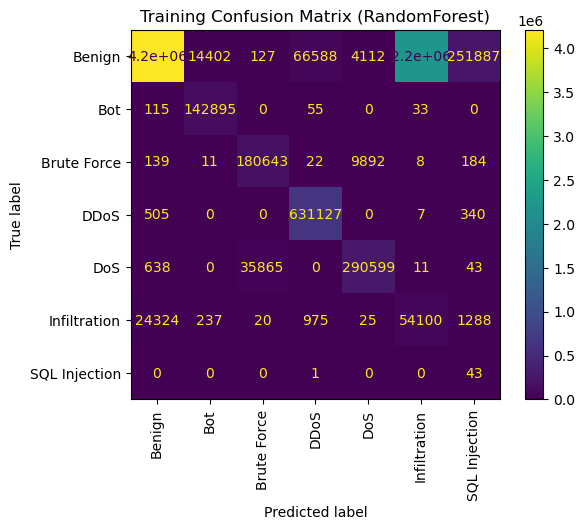

Model: RandomForest - Validation: 
Accuracy: 0.6779, 
Precision: 0.9701, 
Recall: 0.6779, 
F1: 0.7854, 
AUC: 0.9831, 
Balanced Accuracy: 0.8575
               precision    recall  f1-score   support

       Benign       0.99      0.62      0.77   2696807
          Bot       0.91      1.00      0.95     57236
  Brute Force       0.83      0.95      0.89     76354
         DDoS       0.90      1.00      0.95    252774
          DoS       0.95      0.89      0.92    130854
 Infiltration       0.02      0.67      0.05     32385
SQL Injection       0.00      0.88      0.00        17

     accuracy                           0.68   3246427
    macro avg       0.66      0.86      0.65   3246427
 weighted avg       0.97      0.68      0.79   3246427



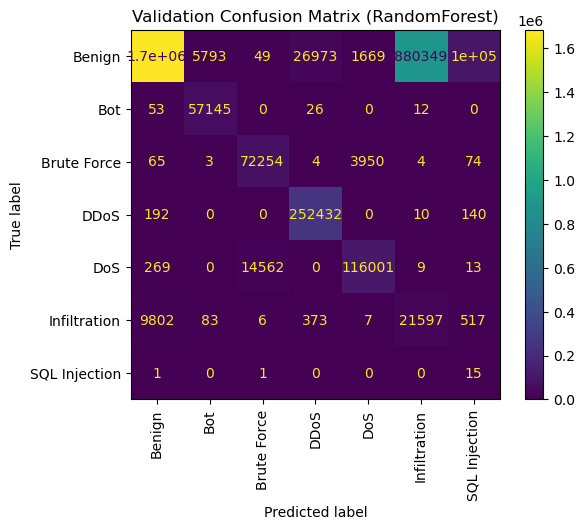

Model: XGBoost - Training: 
Accuracy: 0.9848, 
Precision: 0.9826, 
Recall: 0.9848, 
F1: 0.9808, 
AUC: 0.9939, 
Balanced Accuracy: 0.8321
               precision    recall  f1-score   support

       Benign       0.99      1.00      0.99   6742488
          Bot       1.00      1.00      1.00    143098
  Brute Force       0.84      0.94      0.89    190899
         DDoS       1.00      1.00      1.00    631979
          DoS       0.96      0.90      0.93    327156
 Infiltration       0.71      0.05      0.10     80969
SQL Injection       1.00      0.93      0.96        44

     accuracy                           0.98   8116633
    macro avg       0.93      0.83      0.84   8116633
 weighted avg       0.98      0.98      0.98   8116633



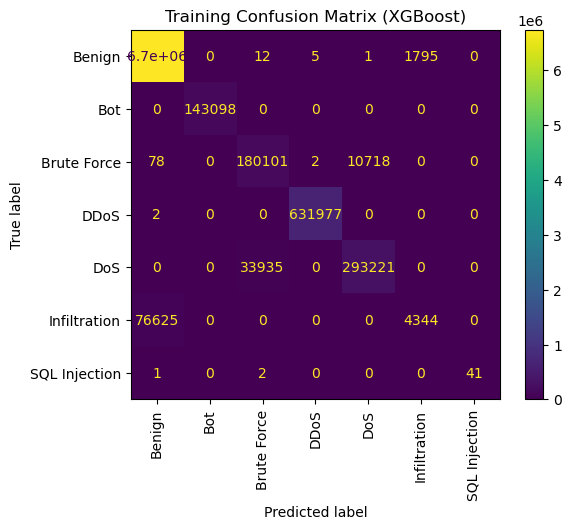

Model: XGBoost - Validation: 
Accuracy: 0.9845, 
Precision: 0.9811, 
Recall: 0.9845, 
F1: 0.9803, 
AUC: 0.9928, 
Balanced Accuracy: 0.8060
               precision    recall  f1-score   support

       Benign       0.99      1.00      0.99   2696807
          Bot       1.00      1.00      1.00     57236
  Brute Force       0.84      0.94      0.89     76354
         DDoS       1.00      1.00      1.00    252774
          DoS       0.96      0.89      0.93    130854
 Infiltration       0.58      0.04      0.07     32385
SQL Injection       0.87      0.76      0.81        17

     accuracy                           0.98   3246427
    macro avg       0.89      0.81      0.81   3246427
 weighted avg       0.98      0.98      0.98   3246427



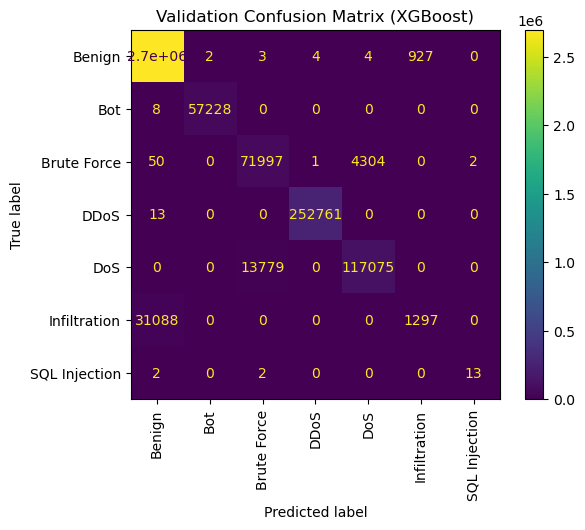

Model: CatBoost - Training: 
Accuracy: 0.9846, 
Precision: 0.9817, 
Recall: 0.9846, 
F1: 0.9803, 
AUC: 0.9912, 
Balanced Accuracy: 0.7415
               precision    recall  f1-score   support

       Benign       0.99      1.00      0.99   6742488
          Bot       1.00      1.00      1.00    143098
  Brute Force       0.84      0.94      0.89    190899
         DDoS       1.00      1.00      1.00    631979
          DoS       0.96      0.90      0.93    327156
 Infiltration       0.65      0.03      0.07     80969
SQL Injection       1.00      0.32      0.48        44

     accuracy                           0.98   8116633
    macro avg       0.92      0.74      0.77   8116633
 weighted avg       0.98      0.98      0.98   8116633



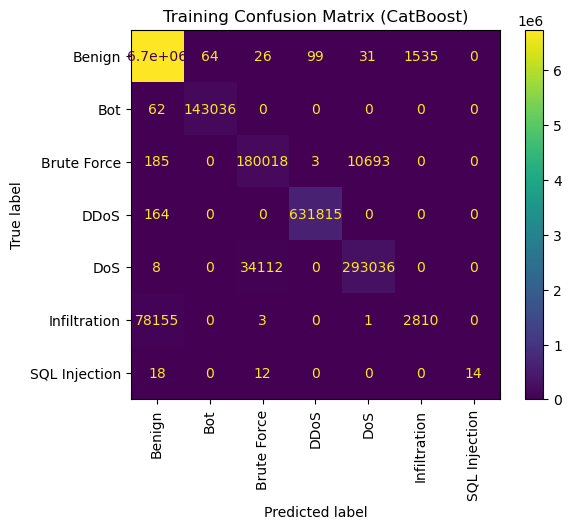

Model: CatBoost - Validation: 
Accuracy: 0.9845, 
Precision: 0.9812, 
Recall: 0.9845, 
F1: 0.9801, 
AUC: 0.9912, 
Balanced Accuracy: 0.7624
               precision    recall  f1-score   support

       Benign       0.99      1.00      0.99   2696807
          Bot       1.00      1.00      1.00     57236
  Brute Force       0.84      0.94      0.89     76354
         DDoS       1.00      1.00      1.00    252774
          DoS       0.96      0.89      0.93    130854
 Infiltration       0.61      0.03      0.06     32385
SQL Injection       1.00      0.47      0.64        17

     accuracy                           0.98   3246427
    macro avg       0.91      0.76      0.79   3246427
 weighted avg       0.98      0.98      0.98   3246427



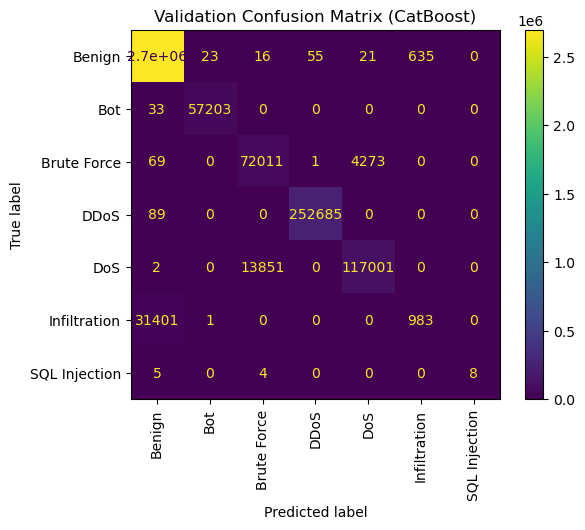

In [18]:
# Create function for model evaluation

def evaluate_model(model, X, y, dataset_name='Dataset'):
    model_name = model["name"]
    clf = model["model"]
    y_pred = clf.predict(X)
    y_proba = clf.predict_proba(X)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=0) # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
    rec = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)
    auc_score = roc_auc_score(label_binarize(y, classes=range(len(le.classes_))), y_proba, average='weighted', multi_class='ovr')
    bal_acc = balanced_accuracy_score(y, y_pred)
    print(f"Model: {model_name} - {dataset_name}: \nAccuracy: {acc:.4f}, \nPrecision: {prec:.4f}, \nRecall: {rec:.4f}, \nF1: {f1:.4f}, \nAUC: {auc_score:.4f}, \nBalanced Accuracy: {bal_acc:.4f}")
    print(classification_report(y, y_pred, target_names=le.classes_))
    ConfusionMatrixDisplay.from_estimator(clf, X, y, display_labels=le.classes_, xticks_rotation=90)
    plt.title(f"{dataset_name} Confusion Matrix ({model_name})")
    plt.show()

# Evaluate on train

for i in range(len(models)):
    evaluate_model(models[i], X_train, y_train, 'Training') # model_trained
    val_metrics= evaluate_model(models[i], X_val, y_val, 'Validation')

## Model Feature Importances

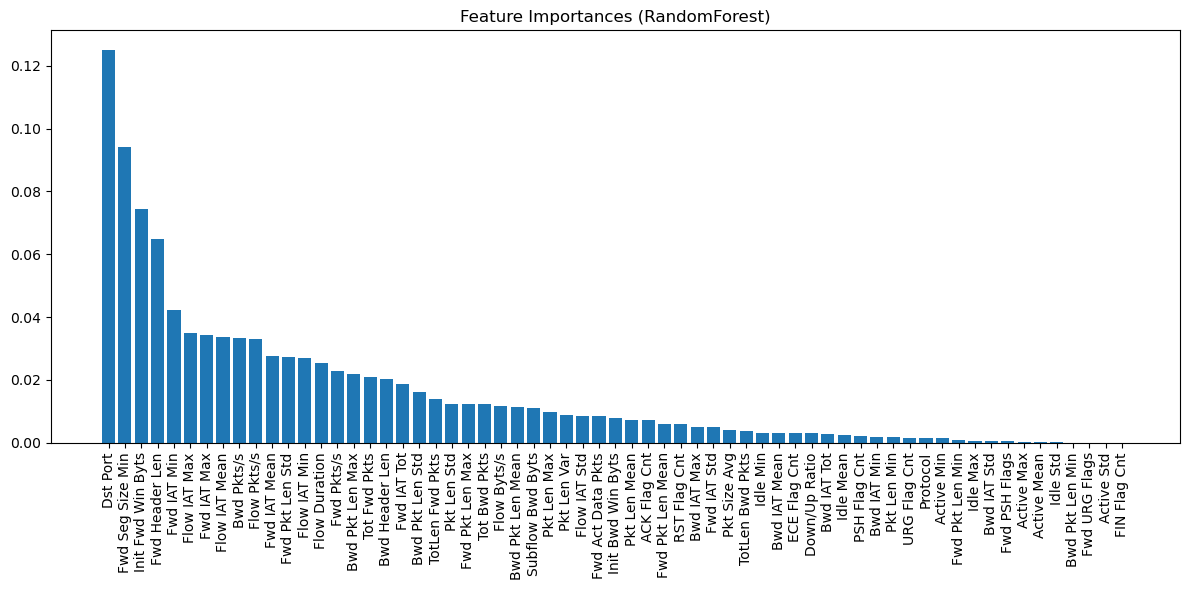

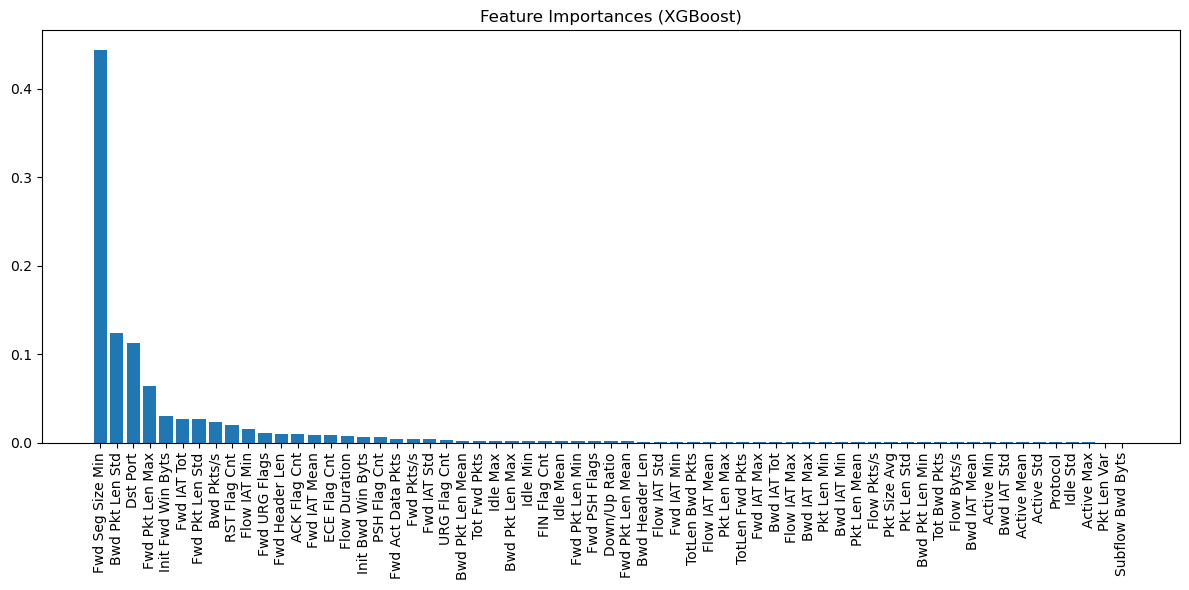

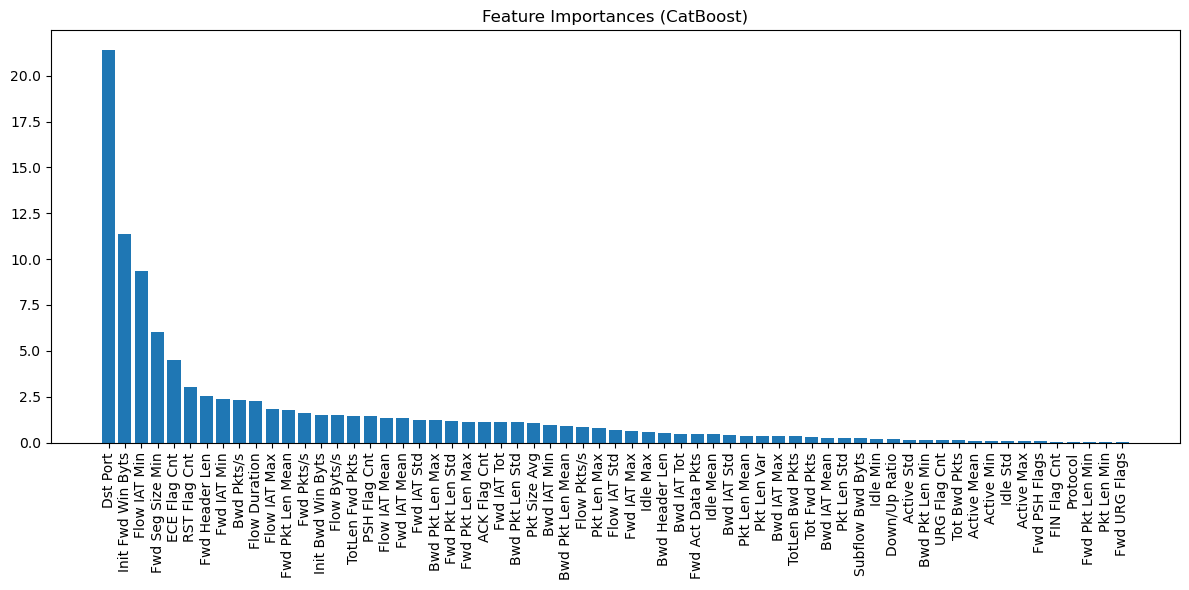

In [19]:
for model in models:

    model_name = model["name"]
    importances = model["model"].feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importances ({model_name})")
    plt.bar(range(len(X_train.columns)), importances[indices])
    plt.xticks(range(len(X_train.columns)), [X_train.columns[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [20]:
#del X_train, y_train, X_val,y_val
gc.collect()

14233

# (Optional) Model Metrics Cross Validation

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, 
                             n_repeats=3, 
                             random_state=random_state)

for i in range(len(models)):
    cv_scores = cross_val_score(models[i],
                                X_train, 
                                y_train, 
                                scoring='accuracy', 
                                cv=cv, 
                                n_jobs=1)
    model_name = str(models[i]).split('(')[0]
    print(model_name)
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    
    plt.figure(figsize=(8, 5))
    plt.plot(cv_scores, marker='o', linestyle='-', color='blue', label='CV Accuracy')
    plt.axhline(mean_score, color='red', linestyle='--', label=f'Mean Accuracy: {mean_score:.4f}')
    plt.fill_between(range(len(cv_scores)), mean_score - std_score, mean_score + std_score, color='red', alpha=0.2, label=f'Std Dev: {std_score:.4f}')
    plt.title(f'Cross-Validation Accuracy Scores ({model_name})')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Final Model Testing

In [26]:
models

[{'name': 'RandomForest',
  'model': RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=50,
                         n_jobs=-1, random_state=42)},
 {'name': 'XGBoost',
  'model': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device='cpu', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                feature_weights=None, gamma=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.1, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, multi_strategy=None, n_estimators=500,
                n_jobs=None, num_class=7, ...)},
 {'name': 'CatBoost',
  'm

## Metrics and Visualization

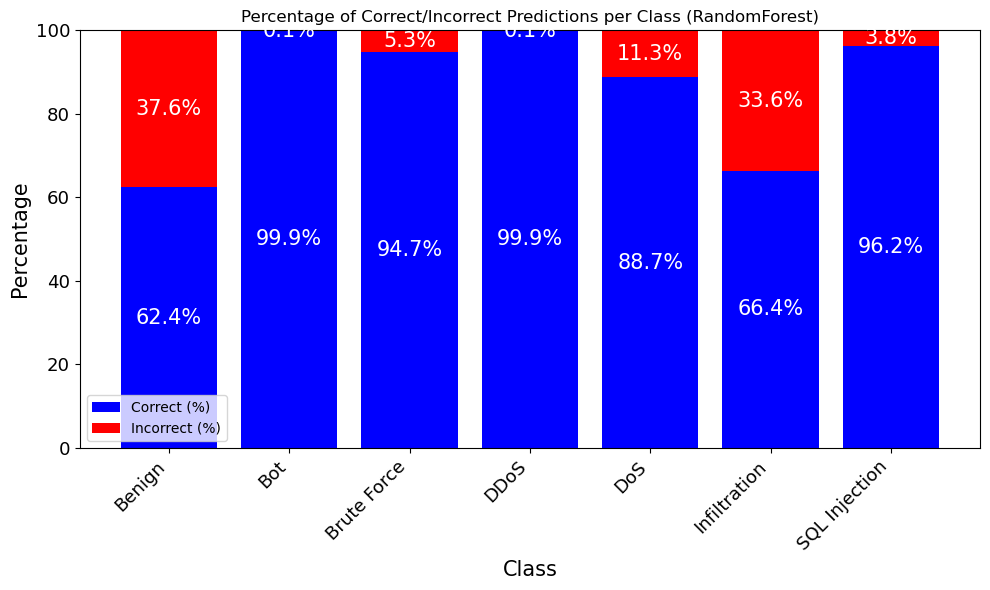

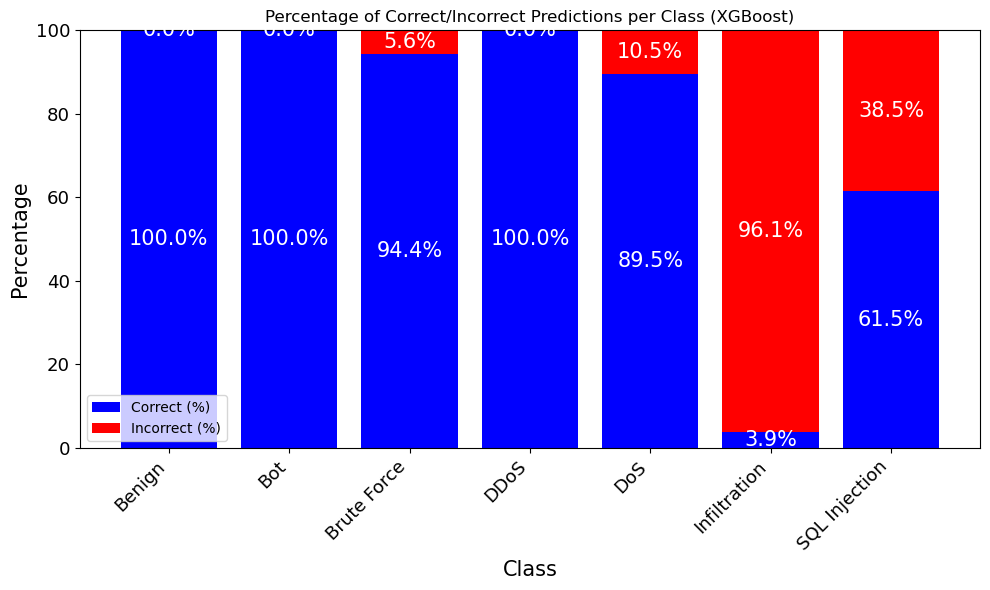

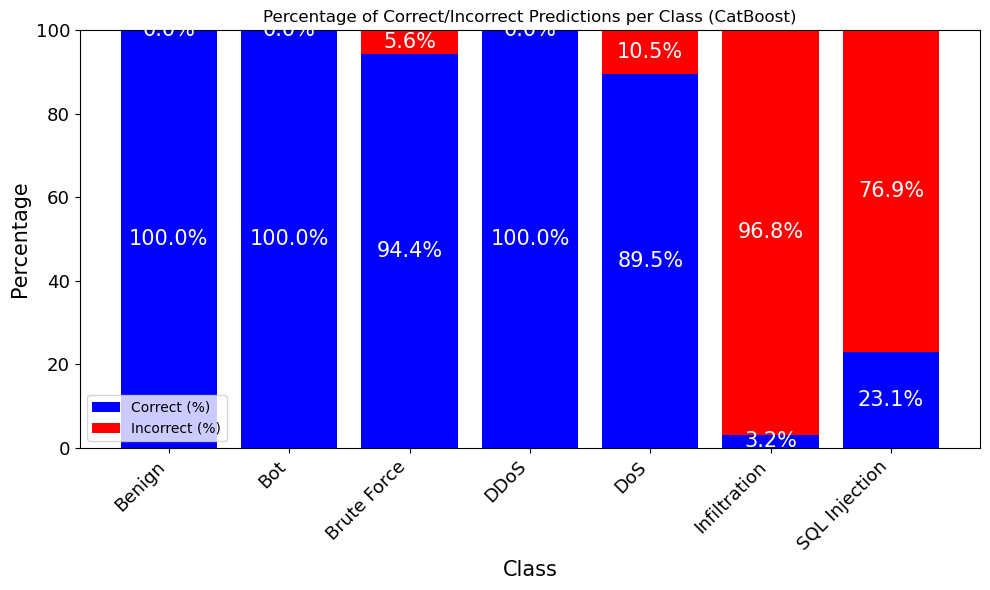

In [21]:
def plot_predictions(model, X, y, class_names):

    y_pred = model['model'].predict(X)
    if hasattr(y_pred, "ravel"):
        y_pred = y_pred.ravel()
        
    cm = confusion_matrix(y, y_pred)

    true_predictions = np.diag(cm)
    total_per_class = cm.sum(axis=1)
    false_predictions = total_per_class - true_predictions

    true_percent = np.divide(true_predictions, total_per_class, out=np.zeros_like(true_predictions, dtype=float), where=total_per_class!=0) * 100
    false_percent = np.divide(false_predictions, total_per_class, out=np.zeros_like(false_predictions, dtype=float), where=total_per_class!=0) * 100

    x = np.arange(len(class_names))

    plt.figure(figsize=(10, 6))
    plt.bar(x, true_percent, label='Correct (%)', color='blue')
    plt.bar(x, false_percent, bottom=true_percent, label='Incorrect (%)', color='red')

    annotation_fontsize = 15 
    
    for i in range(len(class_names)):
        # Label True percentages
        if true_percent[i] > 0:
            plt.text(x[i], true_percent[i] / 2, f'{true_percent[i]:.1f}%', ha='center', va='center', color='white', fontsize=annotation_fontsize)
        # Label False percentages
        if false_percent[i] > 0:
            plt.text(x[i], true_percent[i] + false_percent[i] / 2, f'{false_percent[i]:.1f}%', ha='center', va='center', color='white', fontsize=annotation_fontsize)

    plt.xlabel('Class', fontsize=annotation_fontsize)
    plt.ylabel('Percentage', fontsize=annotation_fontsize)
    plt.title(f"Percentage of Correct/Incorrect Predictions per Class ({model['name']})")
    
    plt.xticks(x, class_names, rotation=45, ha='right', fontsize=13)
    plt.yticks(fontsize=13)
    
    plt.ylim(0, 100)
    plt.legend(loc='lower left', bbox_to_anchor=(0, 0))
    plt.tight_layout()


    filename = f"metrics/final plots/cicids18_{model['name']}_predictions.png"
    
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

for model in models:
    plot_predictions(model, X_test, y_test, le.classes_)

Model - RandomForest - Test: 
Accuracy: 0.6781, 
Precision: 0.9702, 
Recall: 0.6781, 
F1: 0.7856, 
AUC: 0.9831, 
Balanced Accuracy: 0.8686
               precision    recall  f1-score   support

       Benign       0.99      0.62      0.77   4045413
          Bot       0.91      1.00      0.95     85857
  Brute Force       0.83      0.95      0.89    114537
         DDoS       0.90      1.00      0.95    379180
          DoS       0.95      0.89      0.92    196290
Infilteration       0.02      0.66      0.05     48580
SQL Injection       0.00      0.96      0.00        26

     accuracy                           0.68   4869883
    macro avg       0.66      0.87      0.65   4869883
 weighted avg       0.97      0.68      0.79   4869883



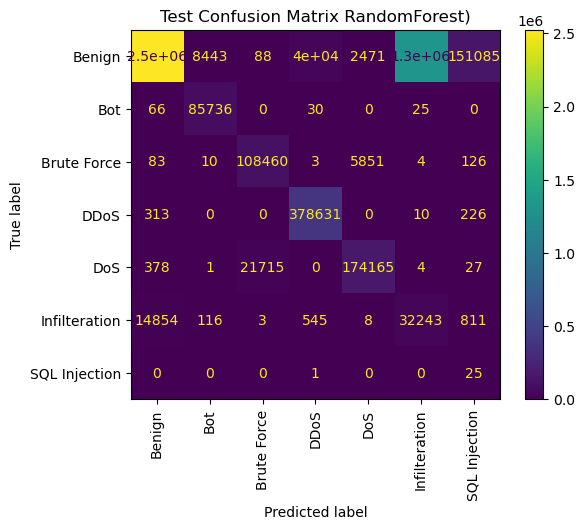

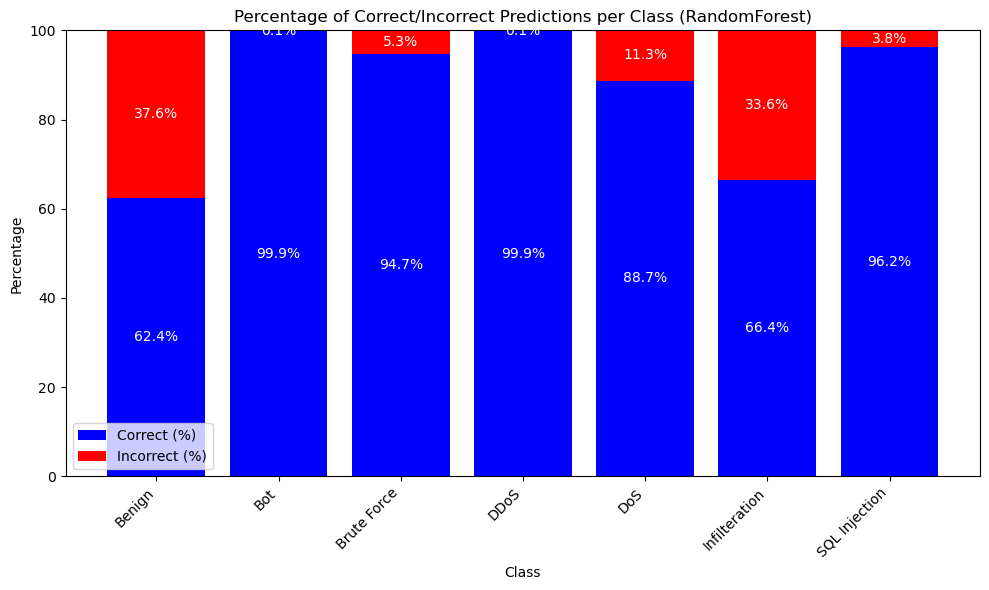

Model - XGBoost - Test: 
Accuracy: 0.9846, 
Precision: 0.9811, 
Recall: 0.9846, 
F1: 0.9804, 
AUC: 0.9927, 
Balanced Accuracy: 0.7847
               precision    recall  f1-score   support

       Benign       0.99      1.00      0.99   4045413
          Bot       1.00      1.00      1.00     85857
  Brute Force       0.84      0.94      0.89    114537
         DDoS       1.00      1.00      1.00    379180
          DoS       0.96      0.90      0.93    196290
Infilteration       0.58      0.04      0.07     48580
SQL Injection       0.80      0.62      0.70        26

     accuracy                           0.98   4869883
    macro avg       0.88      0.78      0.80   4869883
 weighted avg       0.98      0.98      0.98   4869883



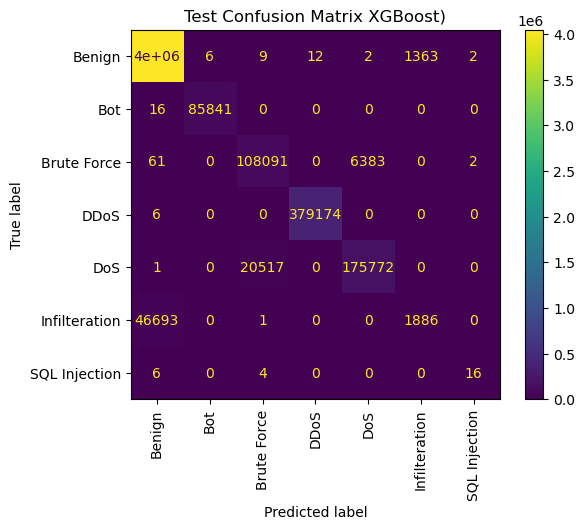

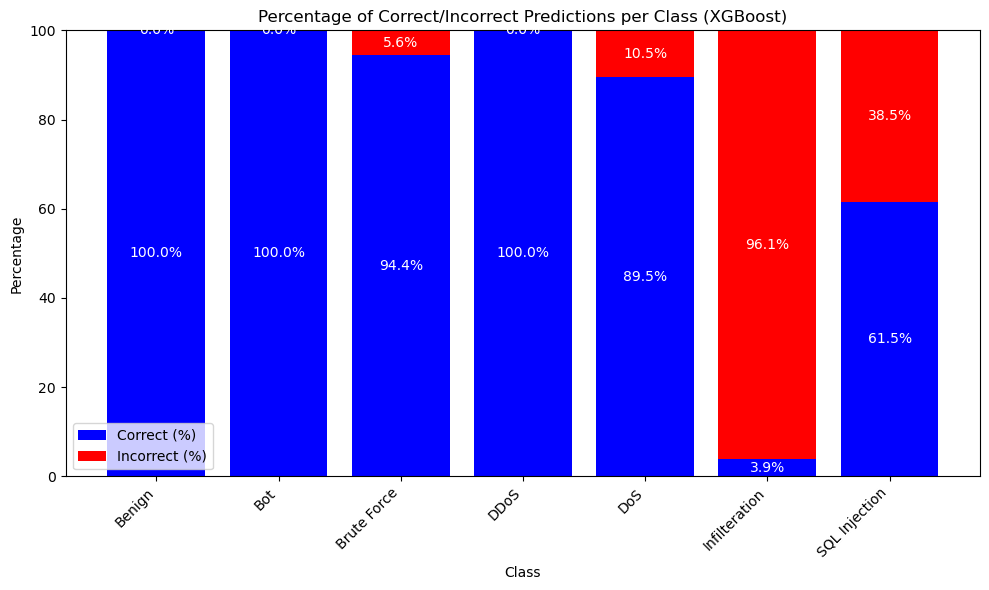

Model - CatBoost - Test: 
Accuracy: 0.9845, 
Precision: 0.9813, 
Recall: 0.9845, 
F1: 0.9802, 
AUC: 0.9911, 
Balanced Accuracy: 0.7286
               precision    recall  f1-score   support

       Benign       0.99      1.00      0.99   4045413
          Bot       1.00      1.00      1.00     85857
  Brute Force       0.84      0.94      0.89    114537
         DDoS       1.00      1.00      1.00    379180
          DoS       0.97      0.89      0.93    196290
Infilteration       0.61      0.03      0.06     48580
SQL Injection       1.00      0.23      0.38        26

     accuracy                           0.98   4869883
    macro avg       0.91      0.73      0.75   4869883
 weighted avg       0.98      0.98      0.98   4869883



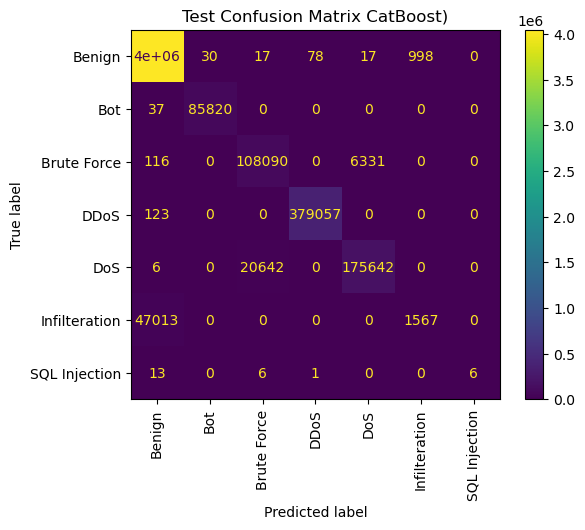

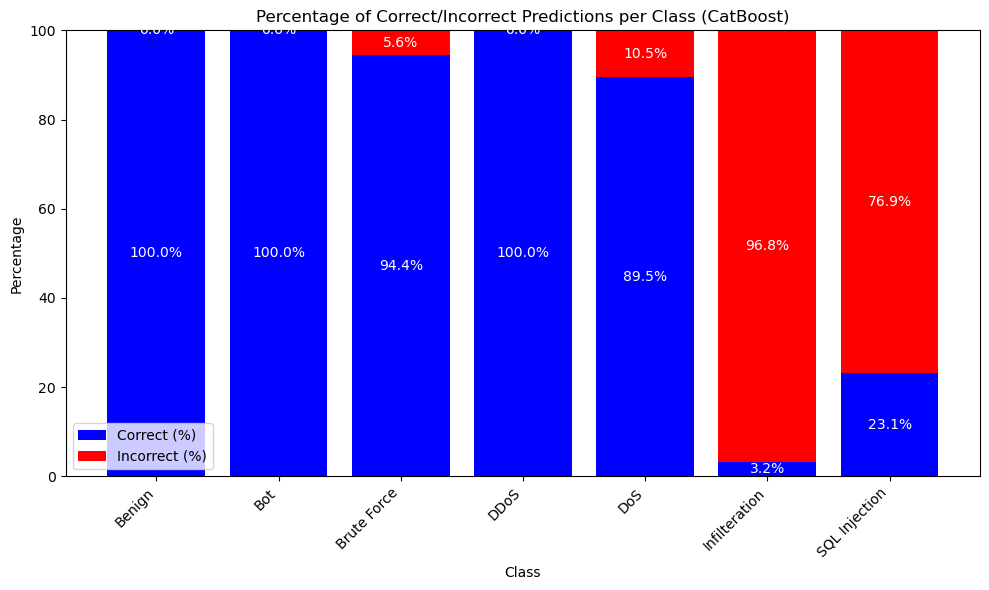

In [27]:
def plot_predictions(model, X, y, class_names):

    # change to dict values, unnecessary computation???
    y_pred = model['model'].predict(X)
    cm = confusion_matrix(y, y_pred)

    true_predictions = np.diag(cm)
    total_per_class = cm.sum(axis=1)
    false_predictions = total_per_class - true_predictions

    true_percent = np.divide(true_predictions, total_per_class, out=np.zeros_like(true_predictions, dtype=float), where=total_per_class!=0) * 100
    false_percent = np.divide(false_predictions, total_per_class, out=np.zeros_like(false_predictions, dtype=float), where=total_per_class!=0) * 100

    x = np.arange(len(class_names))

    plt.figure(figsize=(10, 6))
    bars_true = plt.bar(x, true_percent, label='Correct (%)', color='blue')
    bars_false = plt.bar(x, false_percent, bottom=true_percent, label='Incorrect (%)', color='red')

    for i in range(len(class_names)):
        # True percentages (centered in the blue segment)
        if true_percent[i] > 0:
            plt.text(x[i], true_percent[i] / 2, f'{true_percent[i]:.1f}%', ha='center', va='center', color='white', fontsize=10)
        # False percentages (centered in the red segment)
        if false_percent[i] > 0:
            plt.text(x[i], true_percent[i] + false_percent[i] / 2, f'{false_percent[i]:.1f}%', ha='center', va='center', color='white', fontsize=10)

    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.title(f"Percentage of Correct/Incorrect Predictions per Class ({model['name']})")
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.legend(loc='lower left', bbox_to_anchor=(0, 0))
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X, y, dataset_name='Dataset'):

    y_pred = model["model"].predict(X).ravel() # handle CatBoost output
    y_proba = model["model"].predict_proba(X)

    # append prediction classes as array to modeldict to prevent later calculations
    model["predictions"] = y_pred
    #model["probabilities"] = y_proba

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)
    auc_score = roc_auc_score(label_binarize(y, classes=range(len(le.classes_))),
                              y_proba, average='weighted', multi_class='ovr')
    bal_acc = balanced_accuracy_score(y, y_pred)

    print(f"Model - {model['name']} - {dataset_name}: \nAccuracy: {acc:.4f}, \nPrecision: {prec:.4f}, "
          f"\nRecall: {rec:.4f}, \nF1: {f1:.4f}, \nAUC: {auc_score:.4f}, \nBalanced Accuracy: {bal_acc:.4f}")
    print(classification_report(y, y_pred, target_names=le.classes_))

    ConfusionMatrixDisplay.from_estimator(model['model'], X, y, display_labels=le.classes_, xticks_rotation=90)
    plt.title(f"{dataset_name} Confusion Matrix {model['name']})")
    plt.show()

    plot_predictions(model, X, y, le.classes_)


# Evaluate on test
for model in models:
    evaluate_model(model, X_test, y_test, 'Test')


# Sample Selection

In [24]:
models

[{'name': 'CatBoost',
  'model': <catboost.core.CatBoostClassifier at 0x7e8034cf29b0>,
  'predictions': array([0, 3, 0, ..., 1, 0, 0])}]

In [25]:

# Initialize dictionary and random generator
model_sel_idx_dict = {}
sample_size = 1000
rng = np.random.default_rng(random_state)  # Ensure random_state is defined

for model in models:
    model_name = model["name"]
    #y_test_pred = model["model"].predict(X_test)

    # Convert to numpy arrays
    y_true = np.array(y_test)
    #y_pred = np.array(y_test_pred)
    y_pred = model["predictions"]

    if y_true.ndim > 1:
        y_true = y_true.ravel()
    if y_pred.ndim > 1:
        y_pred = y_pred.ravel()

    # Identify prediction indices
    false_pred_idx = np.where(y_true != y_pred)[0]
    true_pred_idx = np.where(y_true == y_pred)[0]
    all_idx = np.arange(len(y_true))  # All indices in the dataset

    # Select random samples from each category
    selected_false_idx = rng.choice(false_pred_idx, size=min(sample_size, len(false_pred_idx)), replace=False)
    selected_true_idx = rng.choice(true_pred_idx, size=min(sample_size, len(true_pred_idx)), replace=False)
    selected_general_idx = rng.choice(all_idx, size=min(sample_size, len(all_idx)), replace=False)

    # save idx as arrays for efficiency
    model['general_idx'] = selected_general_idx
    model['true_idx'] = selected_true_idx
    model['false_idx'] = selected_false_idx

    print(f"\nClassifier: {model_name}\n")
    print(f"Number of total datapoints: {len(all_idx)}")
    print(f"Number of total correct predictions: {len(true_pred_idx)}")
    print(F"Number of total false predictions: {len(false_pred_idx)}\n")
    print(f"\nGeneral samples available: {len(y_true)}, Selected: {len(selected_general_idx)}")
    print(selected_general_idx[:10])
    print(f"True predictions available: {len(true_pred_idx)}, Selected: {len(selected_true_idx)}")
    print(selected_true_idx[:10])
    print(f"False predictions available: {len(false_pred_idx)}, Selected: {len(selected_false_idx)}")
    print(selected_false_idx[:10])


Classifier: CatBoost

Number of total datapoints: 4869883
Number of total correct predictions: 4794455
Number of total false predictions: 75428


General samples available: 4869883, Selected: 1000
[ 595615 4845201 4824398 1490537 3513341  552811 4141618 3285697 1577072
  492791]
True predictions available: 4794455, Selected: 1000
[1983337 1380454 4443842 3773519  967946  747629  317246 3285374 4779237
 1675819]
False predictions available: 75428, Selected: 1000
[3607298 3873104 2346811 3287214 1841887 1355714 4127133  549939 1101588
 2107840]


In [26]:
print(models[0]["general_idx"][:10])

[ 595615 4845201 4824398 1490537 3513341  552811 4141618 3285697 1577072
  492791]


In [27]:
print(models[0])

{'name': 'CatBoost', 'model': <catboost.core.CatBoostClassifier object at 0x7e8034cf29b0>, 'predictions': array([0, 3, 0, ..., 1, 0, 0]), 'general_idx': array([ 595615, 4845201, 4824398, 1490537, 3513341,  552811, 4141618,
       3285697, 1577072,  492791, 1411395,  176741,  427327, 4728473,
       4165749,  746108, 2251198, 2408246,  720096, 4526673,   81961,
       1079822, 4233288, 3891118,  122726, 2188132,  808396,   67080,
       3181901, 4496363,  937419, 3636377, 4102876,  803240, 1312283,
       1532460,  598504, 4303340, 1531278, 1275271,  248090, 1873218,
       2372111, 1681803,  972893, 1250039, 4544431,  907994, 1581866,
        158709,  664523, 2531111, 4025958, 3723618, 3753620,   73018,
       3926177, 2706953, 1267129, 3683364, 2447659,  963594, 4537462,
       2347477,  282916, 1650784,  472044, 1312577, 3631951,   41963,
       3758486,  218551,  286549, 4029459, 2779050, 1729575,  564298,
       3507297,  447323,  739157, 4142882, 1558978, 1844854, 3926491,
       

# Explanations

In [ ]:
"""
id_to_explain = models[0]["false_idx"][0]
model = models[0]["model"]
true_class = le.inverse_transform([y_test.iloc[id_to_explain]])[0]
predicted_class_name = le.inverse_transform([model.predict(X_test)[id_to_explain]])[0]
predicted_class = model.predict(X_test)[id_to_explain]
"""

## Lime Explainer Setup

In [ ]:
# Create Lime Explainer

limeExplainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_numpy(), # requires 2d numpy array
    feature_names=X_train.columns,
    class_names=le.classes_,
    discretize_continuous=True,
    kernel_width=None, #None, defaults to sqrt (number of columns) * 0.75
    verbose=False,
    mode='classification',
    random_state=random_state
)

### Single Observation Analysis

In [ ]:
id_to_explain = models[0]["false_idx"][0]

true_class = le.inverse_transform([y_test.iloc[id_to_explain]])[0]
predicted_class_name = le.inverse_transform([model.predict(X_test)[id_to_explain]])[0]
predicted_class = model.predict(X_test)[id_to_explain]


exp = limeExplainer.explain_instance(
    data_row=X_test.iloc[id_to_explain].values,
    predict_fn=lambda x: model.predict_proba(pd.DataFrame(x, columns=X_test.columns)),
    num_features=len(X_test.columns), # maximum number of features present in explanation, Extraction of all features
    num_samples=5000,
    top_labels=len(X_test.columns)     # ignore labels and produce explanations for the K labels with highest value
)
print(f"True label: {y_test.values[id_to_explain]} ({true_class})")
print(f"Model predicted label: {model.predict(X_test)[id_to_explain]} ({predicted_class_name})")
#print("Expected values for classes: ", explanation.base_values[0])
print(f"Showing explanation of instance {id_to_explain}\n")
#print(exp.as_list(label=predicted_class)) # returns an already sorted list
for _ in exp.as_list():
    print(_)


#exp.show_in_notebook(show_table=True, show_all=False)

### Multi Observation Analysis

In [ ]:
### Explanation Over Multiple Samples

for m in models[0]["false_idx"][:2]:

    true_class = le.inverse_transform([y_test.iloc[m]])[0]
    predicted_class_name = le.inverse_transform([model.predict(X_test)[m]])[0]
    predicted_class = model.predict(X_test)[m]

    np.random.seed(random_state)  # fix randomness for reproducibility, does not work
    exp = limeExplainer.explain_instance(
        data_row=X_test.iloc[m].values,
        predict_fn=lambda x: model.predict_proba(pd.DataFrame(x, columns=X_test.columns)),
        num_features=7,
        num_samples=5000,
        top_labels=5
        )

    print(f"True label: {y_test.values[m]}:{true_class}")
    print(f"Model predicted label: {model.predict(X_test)[m]}:{predicted_class_name}")
    print(f"Showing explanation of instance {m}\n")

    exp.show_in_notebook(show_table=True, show_all=False)
    #print(exp.as_list())

### Data Acquisition Mutiple Runs Lime

In [36]:
# Set Parameter for Datacollection

# Number of runs
n_runs = 10

# Number of top features to extract
num_features = len(X_test.columns)

output_dir = "explanation_data"
os.makedirs(output_dir, exist_ok=True)

#model = models[0]["model"]

# Create Lime Explainer

limeExplainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_numpy(), # requires 2d numpy array
    feature_names=X_train.columns,
    class_names=le.classes_,
    discretize_continuous=True,
    kernel_width=None, #None, defaults to sqrt (number of columns) * 0.75
    verbose=False,
    mode='classification',
    random_state=random_state
)

In [ ]:
# Set Parameter for Datacollection

# Number of runs
n_runs = 10

# Number of top features to extract
num_features = len(X_test.columns)

output_dir = "explanation_data"
os.makedirs(output_dir, exist_ok=True)

#model = models[0]["model"]

# Create Lime Explainer

limeExplainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_numpy(), # requires 2d numpy array
    feature_names=X_train.columns,
    class_names=le.classes_,
    discretize_continuous=False,
    kernel_width=None, #None, defaults to sqrt (number of columns) * 0.75
    verbose=False,
    mode='classification',
    random_state=random_state
)

sample_sets = ["general_idx", "true_idx", "false_idx"]

for j in range(len(models)):

    rows = []
    model_name = models[j]["name"]
    model = models[j]["model"]
    print(f"Collecting Lime explanations for {model_name}")

    for sample_set in sample_sets:

        print(f"Collecting data for {sample_set}")
        samples = models[j][sample_set]

        for run in range(n_runs):
            run += 1
            start_time = time.perf_counter()
            #print(f"Run: {run}/{n_runs}")

            for i in range(len(samples)):

                idx = samples[i]
                instance = X_test.iloc[idx].values
                #print(f"Classifier: {model_name} Sample Set: {sample_set} Run: {run}/{len(range(n_runs))} Sample: {i}/{len(samples)} {model_name} lime values for idx {idx}")

                exp = limeExplainer.explain_instance(
                    data_row=instance,
                    predict_fn=lambda x: model.predict_proba(pd.DataFrame(x, columns=X_test.columns)),
                    num_features=num_features, # maximum number of features present in explanation, Extraction of all features
                    #top_labels=top_features      # ignore labels and produce explanations for the K labels with highest
                    num_samples=5000, # default
                )

                #print(exp.as_list())

                rows.append({
                    'classifier': model_name,
                    'explainer': 'lime',
                    'sample_set': sample_set,
                    'run_nr': run,
                    'idx': idx,
                    'feature_value_pairs': exp.as_list()
                    })

            end_time = time.perf_counter()
            elapsed = end_time - start_time
            print(f"Run {run}/{n_runs} Time: {elapsed:.2f} seconds")

    lime_df = pd.DataFrame(rows)
    #print(lime_df)
    # Save the DataFrame to CSV
    output_path = os.path.join(output_dir, f"{dataset_name}_{model_name}_lime_explanations.csv")
    lime_df.to_csv(output_path, index=False)

    print(f"DataFrame saved to {output_path}")


## Shap Explainer Setup

In [ ]:
# Create a Treeexplainer Object

model = models[0]["model"]

shapExplainer = shap.TreeExplainer(model,
                                   feature_perturbation="auto" # default, equals tree_path_dependent
                                   )


### Single Observation Analysis

In [ ]:
# Get Explanation for specific observation

id_to_explain = models[0]["false_idx"][0]
instance = X_test.iloc[[id_to_explain]]

explanation = shapExplainer(instance)
#print(explanation)
shap_values = explanation.values
print(shap_values.shape)
print(shap_values)

In [ ]:
true_class = le.inverse_transform([y_test.iloc[id_to_explain]])[0]
predicted_class_name = le.inverse_transform([model.predict(X_test)[id_to_explain]])[0]
#predicted_class = model.predict(X_test)[id_to_explain]
predicted_class = models[0]["predictions"][id_to_explain]

print(f"True label: {y_test.values[id_to_explain]} ({true_class})")
print(f"Model predicted label: {predicted_class} ({predicted_class_name})")
print(f"Showing explanation of instance {id_to_explain}, for class {predicted_class}")

shap.plots.waterfall(explanation[0,:,predicted_class])
# 0 because only a single instance was explained. If the explanation was created on a whole set e.g.: X_test of shape (1000, 54, 9) array (idx, features, label), we have to select single explanations with shapExplanation[id_to_explain,:,predicted_class])
print("Expected values for classes: ", explanation.base_values[0])
#shap.plots.bar(explanation[0,:,predicted_class], max_display=10)

In [ ]:
# For Testing Purposes
#print(X_test.columns.get_loc('Packet Length Mean'))
#print(shap_values[0,38,predicted_class])


# shap_values[idx,feature,class]

# get shap values for instance for all features and labels
print(shap_values[0,:,:].shape)
#print(shap_values[0,:,:])
# get shap values only for one class (0)
print(shap_values[0,:,0].shape)
#print(shap_values[0,:,0])
# get shap values for only first feature for all classes
print(shap_values[0,0,:].shape)
#print(shap_values[0,0,:])
# get explicitly only the first feature value for class 0
print(shap_values[0,0,0].shape)
#print(shap_values[0,0,0])

### Multi Observation Analysis

#### Different Instances

In [ ]:
for m in range(len(models)):

    for i in range(len(models[m]["false_idx"][:1])):

        idx = models[0]["false_idx"][i]
        instance = X_test.iloc[[idx]]
        class_to_explain = models[m]["predictions"][idx]
        #class_to_explain = model.predict(X_test)[idx] # => Lime explains the class predicted by the model
        #class_to_explain = 0

        background = X_test.sample(n=1000,
                                    random_state=random_state
                                    )
        explainer = shap.TreeExplainer(model,
                                       data=background,
                                       #model_output="log_loss"
                                       )
        explanation = explainer(instance)
        #print(f"Run {run}:")
        print(f"SHAP values of instance {idx} for class {class_to_explain}:\n", explanation.values[0,:,class_to_explain])
        #shap.plots.waterfall(explanation[0,:,predicted_class])

In [ ]:
print(type(models[0]["predictions"][0]))
print(models[0]["predictions"])

In [ ]:
arr1 = models[0]["predictions"][:10]
arr2 = models[1]["predictions"][:10]
print(arr1)
print(type(arr1))
print(arr2)
print(type(arr2))


#### Same Instance, Same Background Data

In [ ]:
modelno = 0

for m in range(2):

    for i in range(len(models[modelno]["false_idx"][:1])):

        model = models[modelno]["model"]
        idx = models[modelno]["false_idx"][i]
        instance = X_test.iloc[[idx]]
        #class_to_explain = model.predict(X_test)[idx] # => Lime explains the class predicted by the model
        predicted_class = models[modelno]["predictions"][idx]

        background = X_test.sample(n=1000,
                                    random_state=random_state
                                    )
        explainer = shap.TreeExplainer(model,
                                       #feature_perturbation='auto',
                                       data=background
                                       )
        explanation = explainer(instance)
        #print(f"Run {run}:")
        print(f"SHAP values of instance {idx} for class {predicted_class}:\n", explanation.values[0,:,predicted_class])
        shap.plots.waterfall(explanation[0,:,predicted_class])

#### Same Instance, Different Background Data

In [ ]:
models

In [ ]:
# For same instance using different background data

modelno = 0

for m in range(2):

    for i in range(len(models[modelno]["false_idx"][:1])):

        model = models[modelno]["model"]
        idx = models[modelno]["false_idx"][i]
        instance = X_test.iloc[[idx]]
        #class_to_explain = model.predict(X_test)[idx] # => Lime explains the class predicted by the model
        predicted_class = models[modelno]["predictions"][idx]

        background = X_test.sample(n=1000,
                                    random_state=m
                                    )

        if models[modelno]["name"] == "CatBoost":
            print("Switching to KernelExplainer")
            explainer = shap.KernelExplainer(model.predict_proba,
                                 background)
        else:
            print("Using TreeExplainer")
            explainer = shap.TreeExplainer(model,
                                       data=background)
        explanation = explainer(instance)
        #print(f"Run {run}:")
        print(f"SHAP values of instance {idx} for class {predicted_class}:\n", explanation.values[0,:,predicted_class])
        shap.plots.waterfall(explanation[0,:,predicted_class])

### Data Acquisition Mutiple Runs Shap

In [ ]:
print(models[0]["model"].predict(X_test).shape)
print(models[0]["model"].predict(X_test).ravel()[-30:])
print(models[0]["predictions"].shape)
print(models[0]["predictions"][-30:])

In [37]:
# Set Parameter for Datacollection

# Number of runs
n_runs = 10

output_dir = "explanation_data"
os.makedirs(output_dir, exist_ok=True)

In [38]:
sample_sets = ["general_idx", "true_idx", "false_idx"]

for j in range(len(models)):

    rows = []
    model_name = models[j]["name"]
    model = models[j]["model"]
    print(f"Collecting Shap explanations for {model_name}")

    for sample_set in sample_sets:

        print(f"Collecting data for {sample_set}")
        samples = models[j][sample_set]

        for run in range(n_runs):
            run += 1
            start_time = time.perf_counter()
            print(f"Run: {run}/{n_runs}")

            if model_name == 'CatBoost':
                background = X_test.sample(n=1000, random_state=run)
                explainer = shap.KernelExplainer(model.predict_proba,
                                                     data=background)

            else:
                background = X_test.sample(n=1000, random_state=run)
                explainer = shap.TreeExplainer(model,
                                               data=background)

            for i in range(len(samples)):

                idx = samples[i]
                instance = X_test.iloc[[idx]]
                class_to_explain = models[j]["predictions"][idx]  # Predicted class for this instance
                explanation = explainer(instance)
                # explanation.values shape: (1, n_features, n_classes)
                shap_values = explanation.values[0, :, class_to_explain]

                # sort feature-value pairs by absolute SHAP value
                feature_value_pairs = list(zip(X_test.columns, shap_values))
                sorted_features_value_shap = sorted(feature_value_pairs, key=lambda x: abs(x[1]), reverse=True)

                #for _ in sorted_features_value_shap:
                #    print(_)

                rows.append({
                    'classifier': model_name,
                    'explainer': 'shap',
                    'sample_set': sample_set,
                    'run_nr': run,
                    'idx': idx,
                    'feature_value_pairs': sorted_features_value_shap,
                })

            end_time = time.perf_counter()
            elapsed = end_time - start_time
            print(f"Time taken: {elapsed:.2f} seconds")

    shap_df = pd.DataFrame(rows)

    # Save the DataFrame to CSV
    output_path = os.path.join(output_dir, f"{dataset_name}_{model_name}_shap_mix_explanations.csv")
    shap_df.to_csv(output_path, index=False)

    print(f"DataFrame saved to {output_path}")


Run: 1/10


ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.001464, while the model output was 0.001340. If this difference is acceptable you can set check_additivity=False to disable this check.

### Shap with Kernel Explainer

In [ ]:
sample_sets = ["general_idx", "true_idx", "false_idx"]

for j in range(len(models)):

    rows = []
    model_name = models[j]["name"]
    model = models[j]["model"]
    print(f"Collecting Shap explanations for {model_name}")

    for sample_set in sample_sets:

        print(f"Collecting data for {sample_set}")
        samples = models[j][sample_set]

        for run in range(n_runs):
            run += 1
            start_time = time.perf_counter()
            print(f"Run: {run}/{n_runs}")

            background = X_test.sample(n=1000, random_state=run)
            explainer = shap.KernelExplainer(model.predict_proba,
                                                     data=background)

            for i in range(len(samples)):

                idx = samples[i]
                instance = X_test.iloc[[idx]]
                class_to_explain = models[j]["predictions"][idx]  # Predicted class for this instance
                explanation = explainer(instance)
                # explanation.values shape: (1, n_features, n_classes)
                shap_values = explanation.values[0, :, class_to_explain]

                # Sort feature-value pairs by absolute SHAP value
                feature_value_pairs = list(zip(X_test.columns, shap_values))
                sorted_features_value_shap = sorted(feature_value_pairs, key=lambda x: abs(x[1]), reverse=True)

                #for _ in sorted_features_value_shap:
                #    print(_)

                rows.append({
                    'classifier': model_name,
                    'explainer': 'shap',
                    'sample_pset': sample_set,
                    'run_nr': run,
                    'idx': idx,
                    'feature_value_pairs': sorted_features_value_shap,
                })

            end_time = time.perf_counter()
            elapsed = end_time - start_time
            print(f"Time taken: {elapsed:.2f} seconds")

    shap_df = pd.DataFrame(rows)

    # Save the DataFrame to CSV
    output_path = os.path.join(output_dir, f"{dataset_name}_{model_name}_shap_kernel_explanations.csv")
    shap_df.to_csv(output_path, index=False)

    print(f"DataFrame saved to {output_path}")


Run: 1/10


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Shap with Kernel Explainer (smoothed)

In [30]:
# Set Parameter for Datacollection

# Number of runs
n_runs = 10

output_dir = "explanation_data"
os.makedirs(output_dir, exist_ok=True)

In [31]:
epsilon=1e-16
#epsilon=0.0000000000000001

# necessary helper function to circumvent zero division due to 0.0 predict_proba in random forest
def smoothing_func(X_input):
    # handle feature issues in random forest
    if isinstance(X_input, np.ndarray):
        X_input = pd.DataFrame(X_input, columns=X_test.columns)

    probs = model.predict_proba(X_input)
    probs = np.clip(probs, epsilon, 1 - epsilon)
    probs /= probs.sum(axis=1, keepdims=True)
    return probs

In [32]:
# check propabilities after applying smoothing

for j in range(len(models)):
    model = models[j]["model"]              # Set current model
    model_name = models[j]["name"]

    print(f"Model: {model_name}")
    raw_probs = model.predict_proba(X_test)
    print(f"Min/Max Probs (raw): {raw_probs.min()}, {raw_probs.max()}")

    smoothed_probs = smoothing_func(X_test)
    print(f"Min/Max Probs (with smoothing): {smoothed_probs.min()}, {smoothed_probs.max()}\n")

print("Any NaN in X_test?", X_test.isna().any().any())

Model: CatBoost
Min/Max Probs (raw): 1.8483666555966424e-11, 0.9999952981171868
Min/Max Probs (with smoothing): 1.8483666555966424e-11, 0.999995298117187

Any NaN in X_test? False


In [ ]:
sample_sets = ["general_idx", "true_idx", "false_idx"]

for j in range(len(models)):

    rows = []
    model_name = models[j]["name"]
    model = models[j]["model"]
    print(f"Collecting Shap explanations for {model_name}")

    for sample_set in sample_sets:

        print(f"Collecting data for {sample_set}")
        samples = models[j][sample_set]

        for run in range(n_runs):
            run += 1
            start_time = time.perf_counter()
            #print(f"Run: {run}/{n_runs}")

            #background = X_test.sample(n=1000, random_state=run)

            #if model_name == "XGBoost":
            #    explainer = shap.KernelExplainer(lambda x: model.predict_proba(x),
            #                                     data=background)
            #else:
            #    explainer = shap.KernelExplainer(smothing_func, background)
            background = shap.sample(X_train, 100, random_state=run)
            explainer = shap.KernelExplainer(smoothing_func, background)

            for i in range(len(samples)):

                idx = samples[i]
                instance = X_test.iloc[[idx]]
                class_to_explain = models[j]["predictions"][idx]  # Predicted class for this instance
                explanation = explainer(instance, silent=True)
                # explanation.values shape: (1, n_features, n_classes)
                shap_values = explanation.values[0, :, class_to_explain]

                # Sort feature-value pairs by absolute SHAP value
                feature_value_pairs = list(zip(X_test.columns, shap_values))
                sorted_features_value_shap = sorted(feature_value_pairs, key=lambda x: abs(x[1]), reverse=True)

                #for _ in sorted_features_value_shap:
                #    print(_)

                rows.append({
                    'classifier': model_name,
                    'explainer': 'shap',
                    'sample_set': sample_set,
                    'run_nr': run,
                    'idx': idx,
                    'feature_value_pairs': sorted_features_value_shap,
                })

            end_time = time.perf_counter()
            elapsed = end_time - start_time
            print(f"Run {run}/{n_runs} Time: {elapsed:.2f} seconds")

    shap_df = pd.DataFrame(rows)
    #print(shap_df)

    # Save the DataFrame to CSV
    output_path = os.path.join(output_dir, f"{dataset_name}_{model_name}_shap_kernel_explanations.csv")
    shap_df.to_csv(output_path, index=False)

    print(f"DataFrame saved to {output_path}\n")
